In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA']   = "1"

import time
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import optuna
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_score, recall_score
!pip install umap-learn[plot]
import umap
import umap.plot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

2025-06-03 11:43:11.370313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748950991.847619      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748950991.969646      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.7 MB/s eta 0:00:00
Using device: cuda


/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


### Import Datasets

In [2]:
# train = pd.read_csv(r'train_dataset.csv')
# val = pd.read_csv(r'val_dataset.csv')
# test = pd.read_csv(r'test_dataset.csv')

train = pd.read_csv(r'/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/train_dataset.csv')
val = pd.read_csv(r'/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/val_dataset.csv')
test = pd.read_csv(r'/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/test_dataset.csv')

train.head()

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0


In [3]:
train_clean = train.copy()
val_clean = val.copy()
test_clean = test.copy()

### Pre-Processing

Remove all HTML reference characters

In [4]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'&[a-z]+;', ' ', x))

Remove all non-ASCII characters

In [5]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'[^\x00-\x7F]', '', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'[^\x00-\x7F]', '', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'[^\x00-\x7F]', '', x))

### Data Analysis

Shortest tweet: 1 word(s)
Longest tweet: 57 word(s)


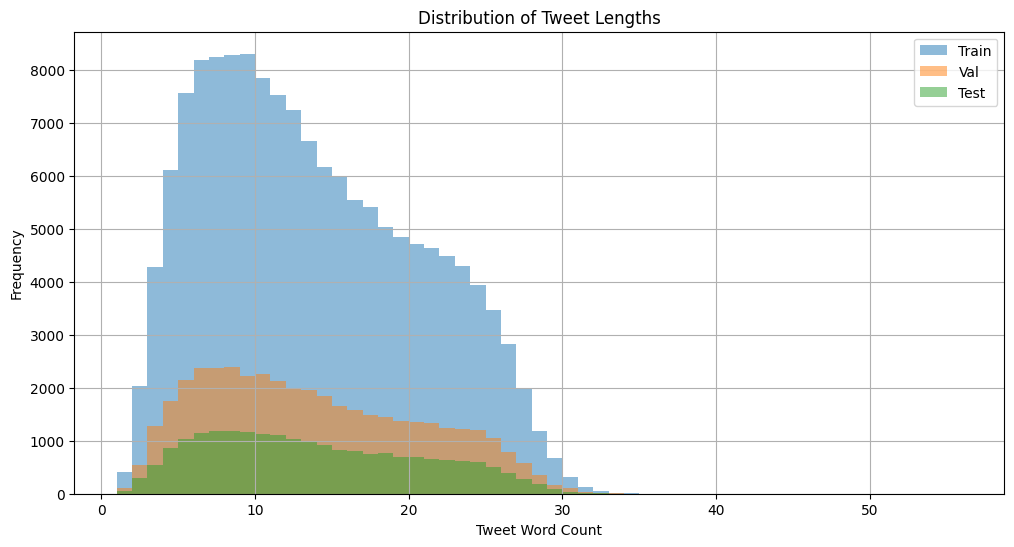

In [6]:
# Calculate tweet lengths, aka the word count
train_lengths = train_clean.Text.str.split().apply(len)
val_lengths = val_clean.Text.str.split().apply(len)
test_lengths = test_clean.Text.str.split().apply(len)

# Find the shortest and longest tweet for all sets
min_len = min(train_lengths.min(), val_lengths.min(), test_lengths.min())
max_len = max(train_lengths.max(), val_lengths.max(), test_lengths.max())
print(f"Shortest tweet: {min_len} word(s)")
print(f"Longest tweet: {max_len} word(s)")

# Plot the word count distributions for each set
plt.figure(figsize=(12,6))
bins = np.arange(min_len, max_len)
plt.hist(train_lengths, bins=bins, alpha=0.5, label='Train')
plt.hist(val_lengths, bins=bins, alpha=0.5, label='Val')
plt.hist(test_lengths, bins=bins, alpha=0.5, label='Test')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### Reproducibility

A function that ensures that results will be reproducable. Follows the steps found in the following documentation: https://pytorch.org/docs/stable/notes/randomness.html

In [7]:
def set_seed(seed):
    random.seed(seed) # seed Python's default RNG
    np.random.seed(seed) # seed the RNG for NumPy
    torch.manual_seed(seed) # seed the RNG for all devices
    torch.cuda.manual_seed_all(seed) # set the seed for generating random numbers on all GPUs
    torch.backends.cudnn.benchmark = False # cause cuDNN to deterministically select an algorithm
    torch.backends.cudnn.deterministic = True # make sure that the above algorithm is deterministic itself

seed = 42
set_seed(seed)

### Necessary Functions

Helper function for formatting elapsed times as `hh:mm:ss`. Taken from the tutorial.

In [8]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Helper function that prints and plots different metrics 

In [9]:
def print_plot_metrics(true, predicted, probs):
    # Compute and print f1, accuracy and roc auc scores
    f1 = f1_score(true, predicted)
    acc = accuracy_score(true, predicted)
    conf_mat = confusion_matrix(true, predicted)
    roc_score = roc_auc_score(true, probs)

    print(f"ROC AUC score: {roc_score}")
    print(f"F1 score: {f1}")
    print(f"Accuracy: {acc}")

    # Plot per class metrics in a barplot
    prec = precision_score(true, predicted)
    rec = recall_score(true, predicted)
    sentiment = np.arange(2)
    bar_width = 0.15

    plt.figure()
    plt.bar(sentiment - 1.5*bar_width, acc, bar_width, label="Accuracy")
    plt.bar(sentiment - 0.5*bar_width, prec, bar_width, label="Precision")
    plt.bar(sentiment + 0.5*bar_width, rec, bar_width, label="Recall")
    plt.bar(sentiment + 1.5*bar_width, f1, bar_width, label="F1")

    plt.xticks(sentiment, ['0', '1'])
    plt.ylim(0, 1)
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("Per-Class Metrics")
    plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.3))
    plt.grid(axis="y", alpha=0.5)
    plt.show()
    
    # Plot confusion matrix
    ConfusionMatrixDisplay(conf_mat).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Plot the distribution of probabilities
    sns.histplot(probs, kde=True, bins=50, legend=False)
    plt.title("Distribution of Probabilities")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.show()

Extract embeddings, labels and probabilities for UMAP visualisation

In [10]:
def extraction(model, data_loader):
    model.eval()   # run the model in eval mode

    # The extracted values will be stored in the lists below
    all_embeds = []
    all_labels = []
    all_probs = []

    # Collect CLS embeddings, labels and probabilities
    for batch in data_loader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, output_hidden_states=True, return_dict=True)
            emb = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            logits = outputs.logits.cpu().numpy()
            # Use softmax to get probabilities and keep the positives
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

        # Update lists
        all_embeds.append(emb)
        all_labels.extend(b_labels.cpu().tolist())
        all_probs.extend(probs)

    # Stack into arrays
    embeds = np.vstack(all_embeds)
    labels = np.array(all_labels)
    probs = np.array(all_probs)

    return embeds, labels, probs

Function to calculate the accuracy of our predictions vs labels. Taken from the tutorial.

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Training function

In [12]:
def train_function(model, train_dataloader, optimizer, scheduler, print_flag=True):
    print("+--Training--+")
    t0 = time.time()   # used to measure how long each epoch takes
    total_train_loss = 0

    model.train()   # training mode
    for step, batch in enumerate(train_dataloader):
        # Print progress update every 600 batches
        if print_flag and (step % 600 == 0) and (step != 0):
            elapsed = format_time(time.time() - t0)   # calculate elapsed time in minutes
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        model.zero_grad()  # set gradients to zero before the next backpropagation      

        # Perform a forward pass
        result = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = result.loss
        total_train_loss += loss.item()  # add the calculated loss

        loss.backward()  # backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip gradients to prevent the exploding gradients problem

        optimizer.step()  # parameter update
        scheduler.step()  # update learning rate


    train_loss = total_train_loss / len(train_dataloader)  # calculate mean of training loss
    training_time = format_time(time.time() - t0)

    print("\n  Average training loss: {0:.2f}".format(train_loss))
    print("  Training epoch took: {:}".format(training_time))

    return train_loss, training_time

Evaluation function

In [13]:
def evaluation_function(model, val_dataloader, print_flag=True):
    print("\n+--Evaluation--+")
    t0 = time.time()   # used to measure how long each epoch takes
    total_eval_accuracy = 0
    total_eval_loss = 0
    all_logits = []
    all_labels = []

    model.eval()  # evaluation mode
    for step, batch in enumerate(val_dataloader):
        # Print progress update every 300 batches
        if step % 300 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(val_dataloader), elapsed))
        # Unpack this training batch from our dataloader
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Perform a forward pass (without constructing the compute graph)
        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()   # add the calculated loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Update lists
        all_logits.append(logits)
        all_labels.append(label_ids)

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Calculate and print accuracy and loss for the validation set
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)
    evaluation_time = format_time(time.time() - t0)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Evaluation took: {:}".format(evaluation_time))

    if print_flag:
        # Stack into (N,2) array
        all_logits = np.vstack(all_logits)
        all_labels = np.concatenate(all_labels)

        # Calculate probabilities
        exps = np.exp(all_logits)
        probs = exps / exps.sum(axis=1, keepdims=True)
        positive_probs = probs[:, 1]
        preds = probs.argmax(axis=1)

        print_plot_metrics(true=all_labels, predicted=preds, probs=positive_probs)

    return avg_val_loss, avg_val_accuracy, evaluation_time

### Tokenisation and Encoding with Dynamic Padding

Load the tokenizer

In [14]:
# max_len = 128
batch_size = 64

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The following code is partly taken from the huggingface documentation (https://huggingface.co/transformers/v3.2.0/custom_datasets.html)

In [15]:
# Tokenize each dataset. Use truncation=True to ensure that all sequances are truncated to not be longer than the 
# model’s maximum input length and add_special_tokens=True to add special tokens in the encoded sequence
train_encodings = tokenizer(train_clean.Text.tolist(), truncation=True, add_special_tokens=True)
val_encodings = tokenizer(val_clean.Text.tolist(), truncation=True, add_special_tokens=True)
test_encodings = tokenizer(test_clean.Text.tolist(), truncation=True, add_special_tokens=True)

# Turn the encodings into a Dataset object. In this format the data can be easily batched such that each key in 
# the batch encoding corresponds to a named parameter of the forward() method of the model we will train.
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None):    # labels=None in the test dataset
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = CustomDataset(train_encodings, train_clean.Label.values)
val_dataset = CustomDataset(val_encodings, val_clean.Label.values)
test_dataset = CustomDataset(test_encodings)

# Use a data collator to dynamically pad the batches
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Create the dataloaders
set_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collator)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collator)

Print the distribution of tweet lengths once more

Shortest tweet: 35 token(s)
Longest tweet: 118 token(s)


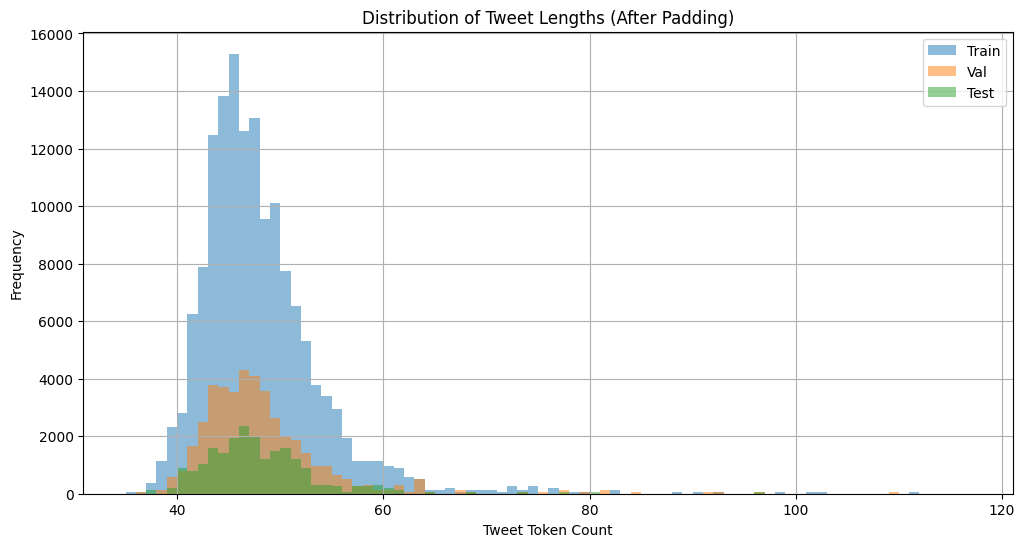

In [16]:
# Calculate tweet lengths, aka the word count, after the padding process
def get_padded_lengths(data_loader):
    all_lengths = []
    for batch in data_loader:
        input_ids = batch['input_ids']
        batch_seq_len = input_ids.shape[1]   # in each batch everything is the same length
        all_lengths.extend([batch_seq_len] * input_ids.shape[0])
    return all_lengths

# Get the padded lengths for all sets
train_padded_lengths = get_padded_lengths(train_loader)
val_padded_lengths = get_padded_lengths(val_loader)
test_padded_lengths = get_padded_lengths(test_loader)

# Find the shortest and longest tweet for all sets
min_pad_len = min(train_padded_lengths + val_padded_lengths + test_padded_lengths)
max_pad_len = max(train_padded_lengths + val_padded_lengths + test_padded_lengths)
print(f"Shortest tweet: {min_pad_len} token(s)")
print(f"Longest tweet: {max_pad_len} token(s)")

# Plot the word count distributions for each set
plt.figure(figsize=(12,6))
bins = np.arange(min_pad_len, max_pad_len)
plt.hist(train_padded_lengths, bins=bins, alpha=0.5, label='Train')
plt.hist(val_padded_lengths, bins=bins, alpha=0.5, label='Val')
plt.hist(test_padded_lengths, bins=bins, alpha=0.5, label='Test')
plt.title('Distribution of Tweet Lengths (After Padding)')
plt.xlabel('Tweet Token Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### Base Case

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



+--Evaluation--+
  Batch   300  of    663.    Elapsed: 0:00:25.
  Batch   600  of    663.    Elapsed: 0:00:50.
  Accuracy: 0.48
  Validation Loss: 0.70
  Evaluation took: 0:00:55
ROC AUC score: 0.42529649423020033
F1 score: 0.11644624488661186
Accuracy: 0.4752570997263893


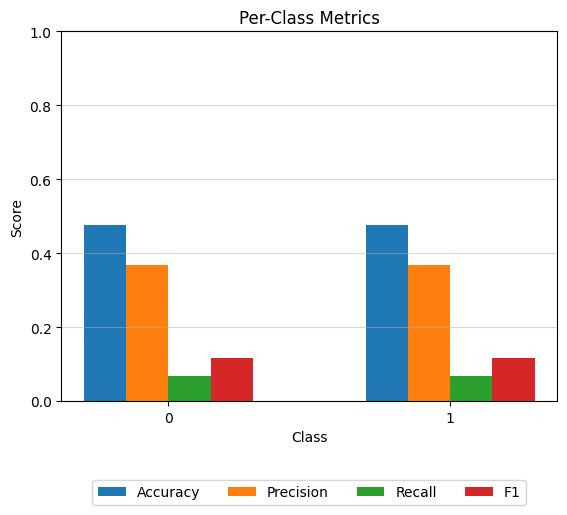

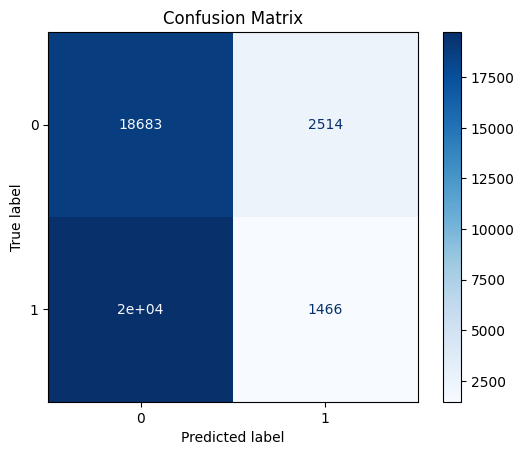

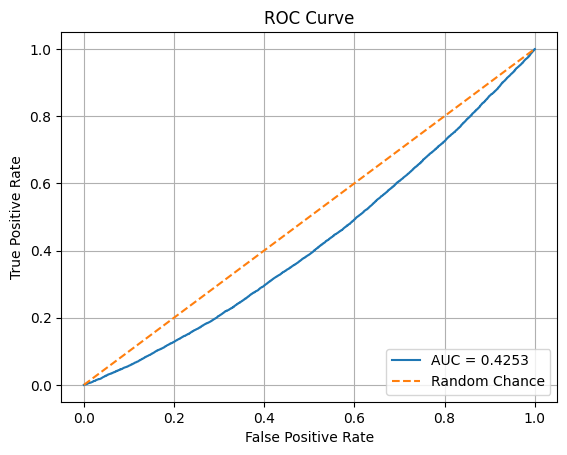

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


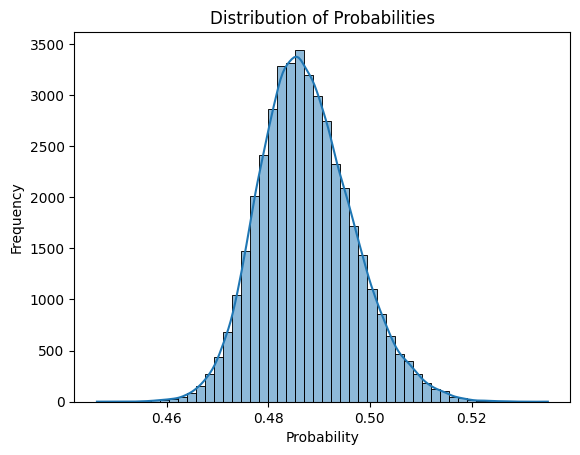

Untrained BERT — Val Loss: 0.70, Val Acc: 0.48


In [17]:
set_seed(seed)

# Load a pretrained model
untrained_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
untrained_model.to(device)

# Evaluate it
val_loss_untrained, val_acc_untrained, _ = evaluation_function(untrained_model, val_loader)
print(f'Untrained BERT — Val Loss: {val_loss_untrained:.2f}, Val Acc: {val_acc_untrained:.2f}')

UMAP coloured by label (https://umap-learn.readthedocs.io/en/latest/plotting.html)

<Axes: >

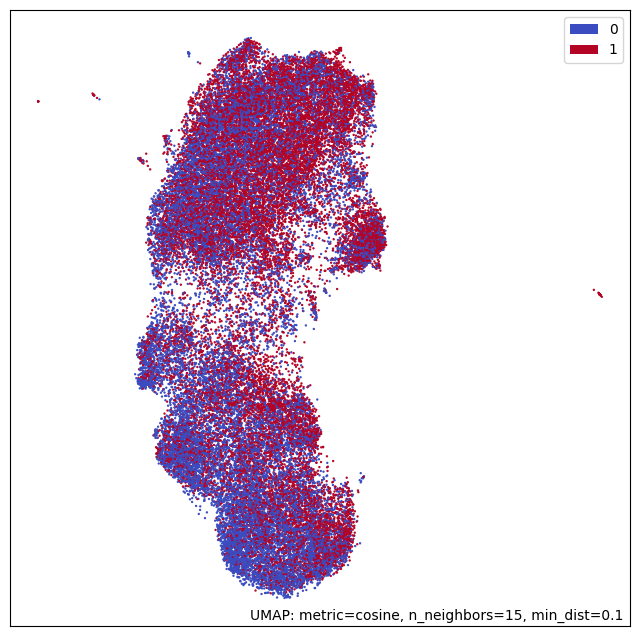

In [18]:
set_seed(seed)
embeds, labels, probs = extraction(untrained_model, val_loader)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine")
embedding = reducer.fit_transform(embeds)
umap.plot.points(reducer, labels=labels, color_key_cmap='coolwarm', background='white')

UMAP coloured by probability. A higher probability means positive sentiment and is represented by the colour red, while a lower probability means negative sentiment and is represented by the colour blue

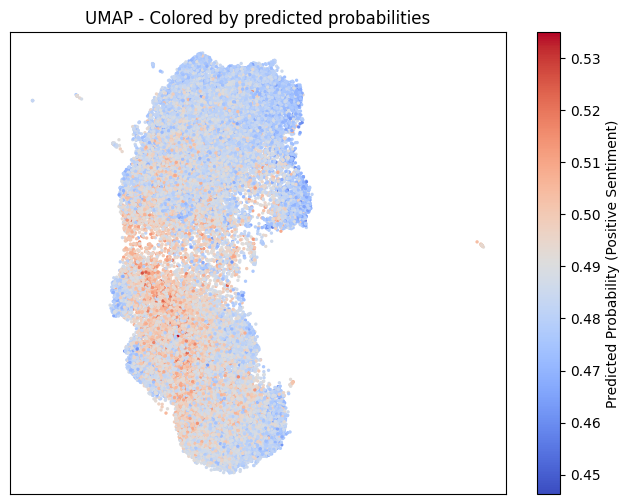

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=probs, cmap='coolwarm', s=2)
plt.colorbar(scatter, label='Predicted Probability (Positive Sentiment)')
plt.title('UMAP - Colored by predicted probabilities')
plt.xticks([])
plt.yticks([])
plt.show()

### Optuna hyperparameter tuning

Use optuna to determine the learning rate while keeping the optimizer and scheduler constant.

In [20]:
def suggest_model(trial):
    # Define the hyperparameters to be suggested
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-3)
    
    # Initialize model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Initialize scheduler
    epoch_num = 3
    warmup_steps = 475
    total_steps = len(train_loader) * epoch_num
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    return model, optimizer, scheduler

In [21]:
# Optuna architecture and hyperparameter tuning
def objective(trial):
    set_seed(seed)
    model, optimizer, scheduler = suggest_model(trial)
    _, _ = train_function(model, train_loader, optimizer, scheduler, print_flag=False)
    val_loss, _, _ = evaluation_function(model, val_loader, print_flag=False)

    return val_loss

Call Optuna. Commented out for time efficiency

In [22]:
# # Initialize pruner
# pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0, interval_steps=1, n_min_trials=10)

# # Call optuna to determine the best model
# study = optuna.create_study(sampler=optuna.samplers.TPESampler(multivariate=True), direction = 'minimize', study_name = 'best-model', pruner=pruner)
# study.optimize(objective, n_trials = 30)

# # Print results
# print('Numbers of the finished trials:', len(study.trials))
# print('Best params:', study.best_trial.params)
# print('Best value:', study.best_value)

### Finetuning DistilBERT

In [23]:
# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
model.to(device)

# Initialize optimizer and scheduler according to Optuna's results
optimizer = torch.optim.AdamW(model.parameters(), lr=4.2307241058454095e-05, eps=1e-8)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=475, num_training_steps=total_steps)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train the model and evaluate it


+++++++++ Epoch 1 / 3 +++++++++
+--Training--+
  Batch   600  of  2,319.    Elapsed: 0:02:45.
  Batch 1,200  of  2,319.    Elapsed: 0:05:29.
  Batch 1,800  of  2,319.    Elapsed: 0:08:15.

  Average training loss: 0.41
  Training epoch took: 0:10:38

+--Evaluation--+
  Batch   300  of    663.    Elapsed: 0:00:27.
  Batch   600  of    663.    Elapsed: 0:00:55.
  Accuracy: 0.84
  Validation Loss: 0.36
  Evaluation took: 0:01:00
ROC AUC score: 0.9227065030779226
F1 score: 0.8445881945246622
Accuracy: 0.8413293706953486


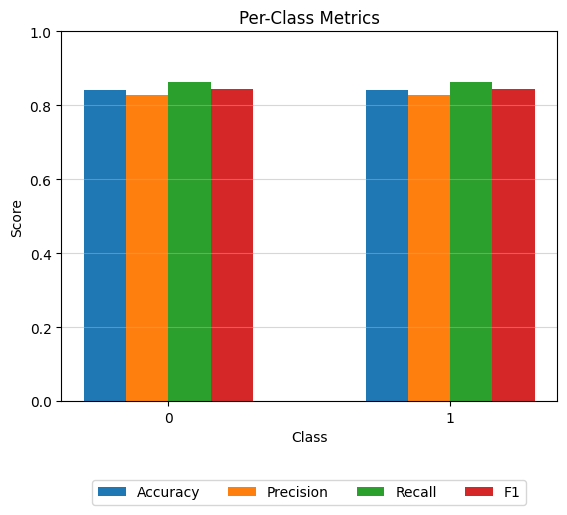

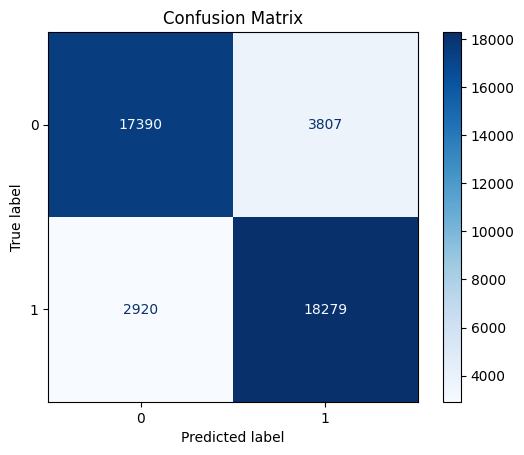

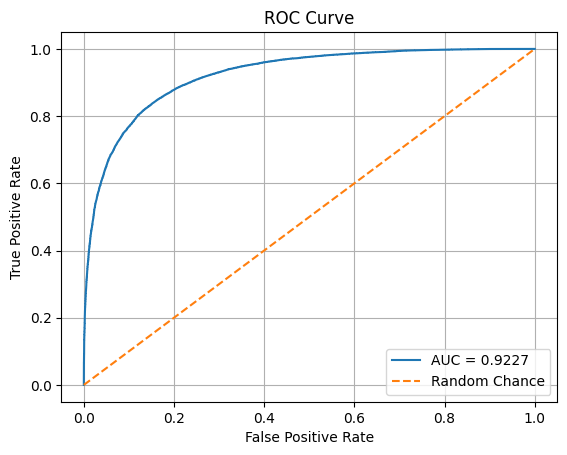

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


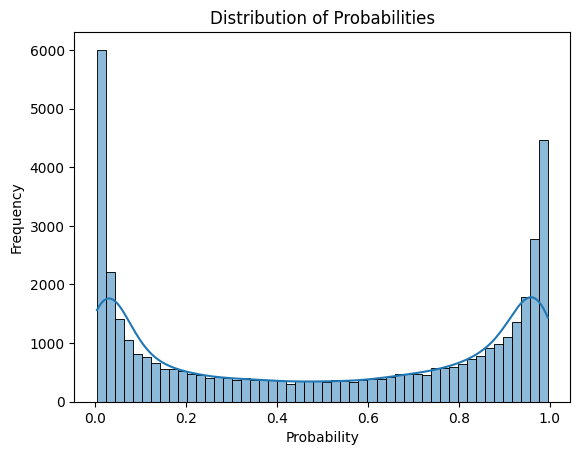


+++++++++ Epoch 2 / 3 +++++++++
+--Training--+
  Batch   600  of  2,319.    Elapsed: 0:02:45.
  Batch 1,200  of  2,319.    Elapsed: 0:05:29.
  Batch 1,800  of  2,319.    Elapsed: 0:08:13.

  Average training loss: 0.29
  Training epoch took: 0:10:35

+--Evaluation--+
  Batch   300  of    663.    Elapsed: 0:00:27.
  Batch   600  of    663.    Elapsed: 0:00:54.
  Accuracy: 0.85
  Validation Loss: 0.36
  Evaluation took: 0:01:00
ROC AUC score: 0.9258967543322292
F1 score: 0.8496192014770367
Accuracy: 0.8463062553071045


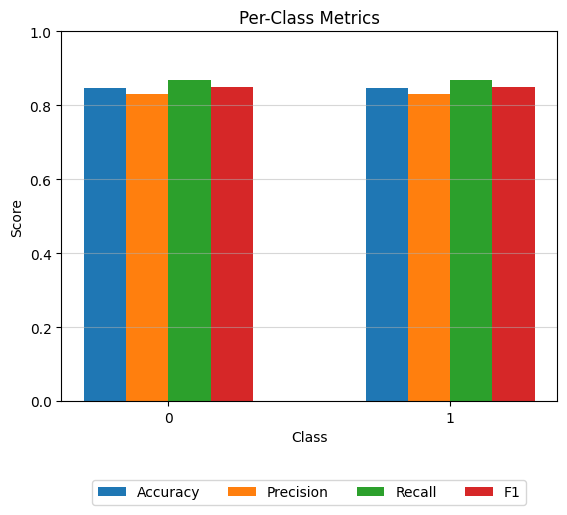

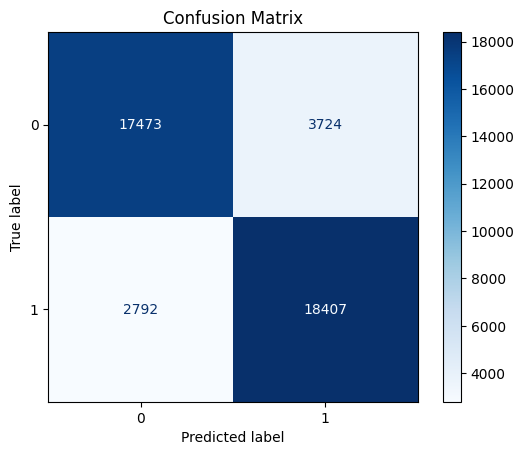

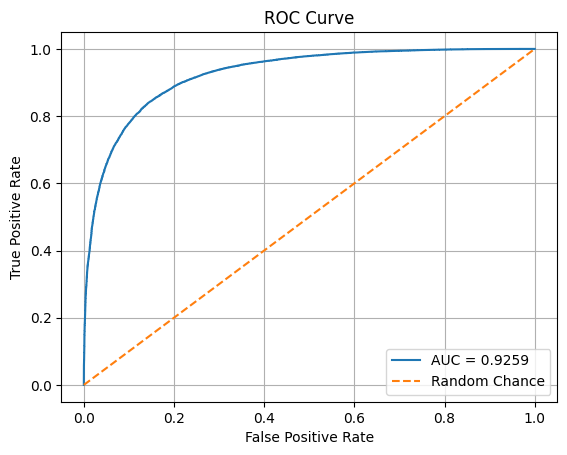

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


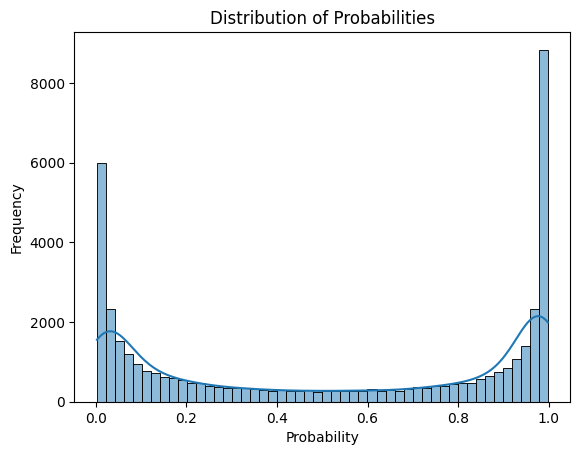


+++++++++ Epoch 3 / 3 +++++++++
+--Training--+
  Batch   600  of  2,319.    Elapsed: 0:02:44.
  Batch 1,200  of  2,319.    Elapsed: 0:05:28.
  Batch 1,800  of  2,319.    Elapsed: 0:08:12.

  Average training loss: 0.19
  Training epoch took: 0:10:35

+--Evaluation--+
  Batch   300  of    663.    Elapsed: 0:00:27.
  Batch   600  of    663.    Elapsed: 0:00:55.
  Accuracy: 0.85
  Validation Loss: 0.42
  Evaluation took: 0:01:00
ROC AUC score: 0.9233677149611195
F1 score: 0.8465703544321755
Accuracy: 0.8469431078403623


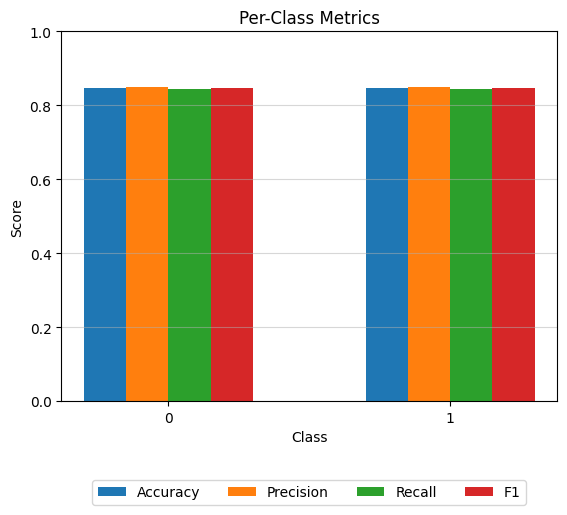

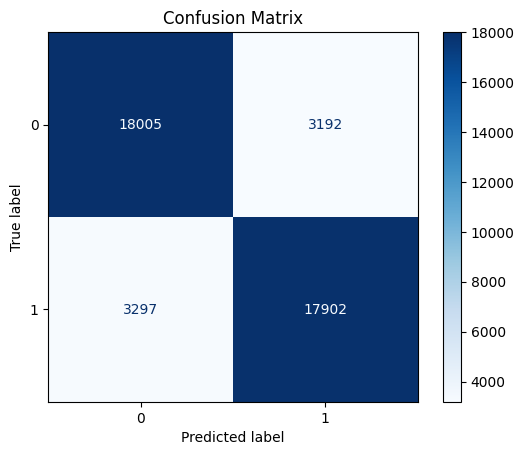

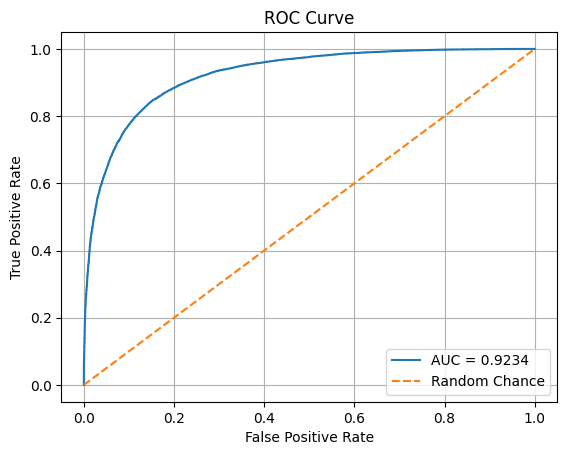

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


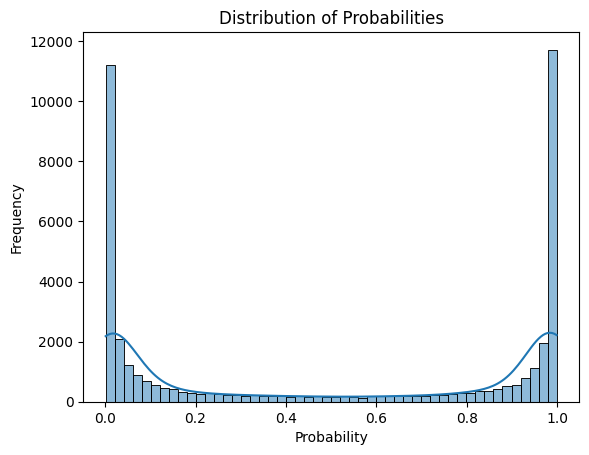


Training complete!
Total training took 0:34:51 (h:mm:ss)


In [24]:
training_stats = []  # dictionary that will hold some statistics for the model
total_t0 = time.time()

set_seed(seed)
for epoch_i in range(0, epochs):
    print(f'\n+++++++++ Epoch {epoch_i + 1} / {epochs} +++++++++')
            
    avg_train_loss, training_time = train_function(model, train_loader, optimizer, scheduler)
    avg_val_loss, avg_val_accuracy, evaluation_time = evaluation_function(model, val_loader)
    
    training_stats.append({
        'Epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Validation Loss': avg_val_loss,
        'Validation Accuracy': avg_val_accuracy,
        'Training Time': training_time,
        'Evaluation Time': evaluation_time
    })

print("\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")

Plot the statistics

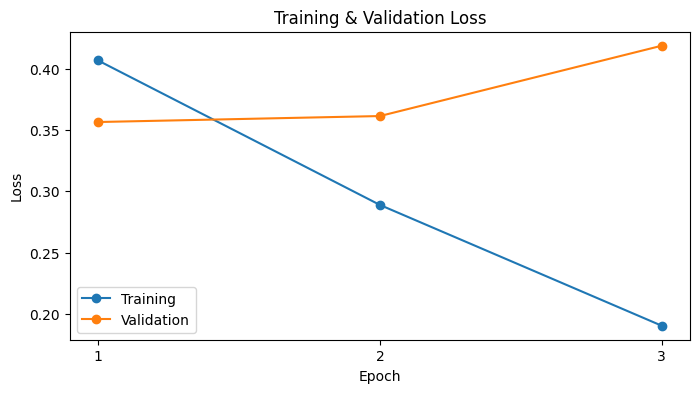

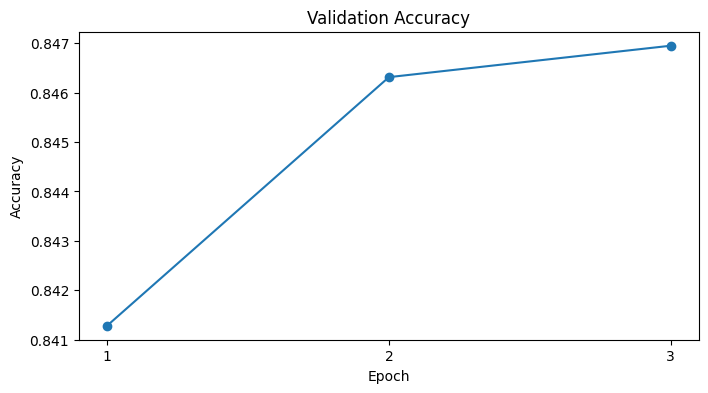

In [25]:
# Create a dataframe from the training statistics
df_stats = pd.DataFrame(training_stats)
df_stats = df_stats.set_index('Epoch')

# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(df_stats['Training Loss'], '-o', label='Training')
plt.plot(df_stats['Validation Loss'], '-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3])
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8,4))
plt.plot(df_stats['Validation Accuracy'], '-o', label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3])
plt.show()

UMAP plot coloured by label

<Axes: >

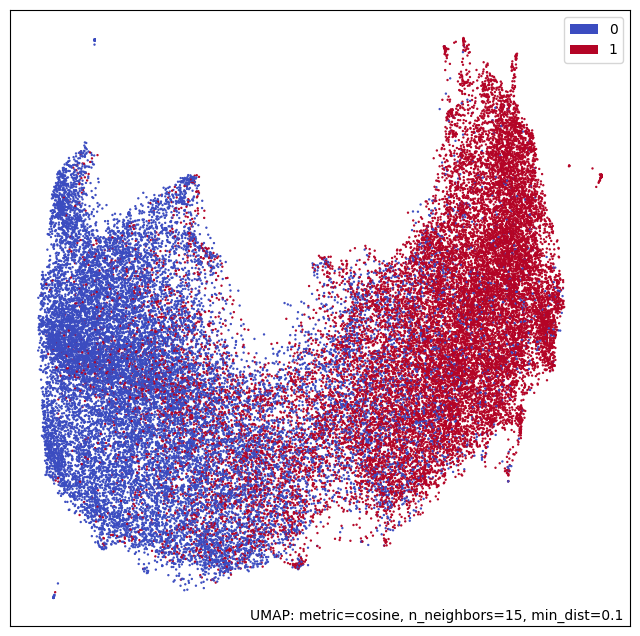

In [26]:
set_seed(seed)
embeds, labels, probs = extraction(model, val_loader)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine")
embedding = reducer.fit_transform(embeds)
umap.plot.points(reducer, labels=labels,  color_key_cmap='coolwarm', background='white')

UMAP coloured by probability

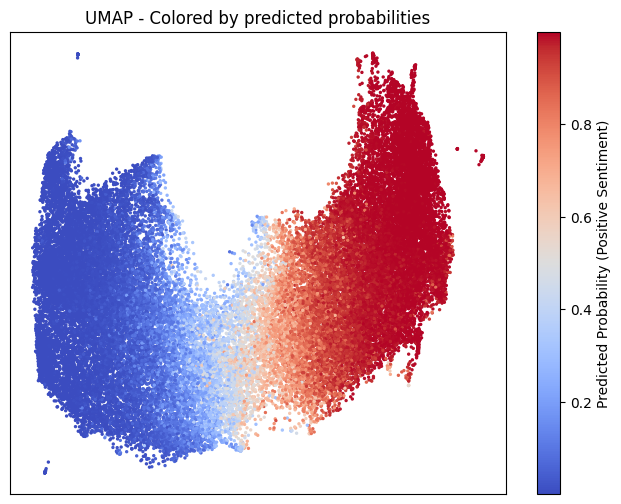

In [27]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=probs, cmap='coolwarm', s=2)
plt.colorbar(scatter, label='Predicted Probability (Positive Sentiment)')
plt.title('UMAP - Colored by predicted probabilities')
plt.xticks([])
plt.yticks([])
plt.show()

### Combining the training and validation datasets

In [28]:
set_seed(seed)

# Combine the datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collator)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
model.to(device)

# Initialize optimizer and scheduler according to Optuna's results
optimizer = torch.optim.AdamW(model.parameters(), lr=4.2307241058454095e-05, eps=1e-8)
epochs = 3
total_steps = len(combined_loader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=475, num_training_steps=total_steps)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train the model once more

In [29]:
training_stats = []
total_t0 = time.time()

set_seed(seed)
for epoch_i in range(0, epochs):
    print(f'\n+++++++++ Epoch {epoch_i + 1} / {epochs} +++++++++')
            
    avg_train_loss, training_time = train_function(model, combined_loader, optimizer, scheduler)

print("\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")


+++++++++ Epoch 1 / 3 +++++++++
+--Training--+
  Batch   600  of  2,981.    Elapsed: 0:02:45.
  Batch 1,200  of  2,981.    Elapsed: 0:05:30.
  Batch 1,800  of  2,981.    Elapsed: 0:08:14.
  Batch 2,400  of  2,981.    Elapsed: 0:10:59.

  Average training loss: 0.40
  Training epoch took: 0:13:38

+++++++++ Epoch 2 / 3 +++++++++
+--Training--+
  Batch   600  of  2,981.    Elapsed: 0:02:44.
  Batch 1,200  of  2,981.    Elapsed: 0:05:30.
  Batch 1,800  of  2,981.    Elapsed: 0:08:13.
  Batch 2,400  of  2,981.    Elapsed: 0:10:57.

  Average training loss: 0.29
  Training epoch took: 0:13:37

+++++++++ Epoch 3 / 3 +++++++++
+--Training--+
  Batch   600  of  2,981.    Elapsed: 0:02:46.
  Batch 1,200  of  2,981.    Elapsed: 0:05:31.
  Batch 1,800  of  2,981.    Elapsed: 0:08:14.
  Batch 2,400  of  2,981.    Elapsed: 0:10:58.

  Average training loss: 0.19
  Training epoch took: 0:13:37

Training complete!
Total training took 0:40:52 (h:mm:ss)


### Calculate predicitions for the test dataset

In [30]:
def inference(dataloader, model):
    t0 = time.time()
    all_logits = []

    model.eval()
    for step, batch in enumerate(dataloader):
        # Print progress update every 300 batches
        if step % 300 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))
        # Unpack this training batch from our dataloader
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        all_logits.append(logits)

    all_logits = np.vstack(all_logits)
    # Calculate probabilities
    exps = np.exp(all_logits)
    probs = exps / exps.sum(axis=1, keepdims=True)
    preds = probs.argmax(axis=1)

    return preds

Create a dataframe with the test predictions

In [31]:
test_prediction = inference(test_loader, model)

output = pd.DataFrame(data=test_clean['ID'])
output['Label'] = test_prediction
output.to_csv('submission.csv', index=False)

  Batch   300  of    332.    Elapsed: 0:00:27.


### Appendix

Below are code snippets from experiments that were not used in the final notebook

Tokenize the data using DistilBERT's tokenizer

In [32]:
# def tokenize_sentences(sentences, tokenizer, max_len):
#     encoded_dicts = []
#     for sent in sentences:
#         encoded_dict = tokenizer.encode_plus(
#             sent,    # sentence to encode
#             add_special_tokens=True,   # add [CLS] and [SEP] tokens
#             max_length=max_len,    # pad and truncate all sentences
#             pad_to_max_length=True,    
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'    # return pytorch tensors
#         )
#         encoded_dicts.append(encoded_dict)
#     return encoded_dicts

Add encoded sentences and their attention masks to lists. Convert them to tensors

In [33]:
# def encode_tensors(encoded_dicts):
#     input_ids = []
#     attention_masks = []
#     for enc in encoded_dicts:
#         input_ids.append(enc['input_ids'])
#         attention_masks.append(enc['attention_mask'])
#     input_ids = torch.cat(input_ids, dim=0)
#     attention_masks = torch.cat(attention_masks, dim=0)
#     return input_ids, attention_masks

Build dataloaders from tensor datasets

In [34]:
# def build_dataloader(input_ids, attention_masks, labels, batch_size, randomize=True):
#     data = TensorDataset(input_ids, attention_masks, labels)
#     sampler = RandomSampler(data) if randomize else SequentialSampler(data)
#     return DataLoader(data, sampler=sampler, batch_size=batch_size, pin_memory=True)

Call the above functions to create the final dataloaders

In [35]:
# # Tokenize and encode for train set
# train_encs = tokenize_sentences(train_clean.Text.values, tokenizer, max_len)
# train_inputs, train_masks = encode_tensors(train_encs)
# train_labels = torch.tensor(train_clean.Label.values)
# train_loader = build_dataloader(train_inputs, train_masks, train_labels, batch_size, randomize=True)

# # Tokenize and encode for validation set
# val_encs = tokenize_sentences(val_clean.Text.values, tokenizer, max_len)
# val_inputs, val_masks = encode_tensors(val_encs)
# val_labels = torch.tensor(val_clean.Label.values)
# val_loader = build_dataloader(val_inputs, val_masks, val_labels, batch_size, randomize=False)

# print(f'Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}')

Use optuna to determine the best values for the optimizer, learning rate, scheduler (and its warmup steps)

In [36]:
# def suggest_model(trial):
#     # Define the hyperparameters to be suggested
#     optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "Adam"])
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-3)
#     scheduler_name = trial.suggest_categorical("scheduler_name", ["linear", "cosine"])
#     warmup_steps = trial.suggest_int("warmup_steps", 0, 750)

#     # Initialize model
#     model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

#     # Initialize optimizer
#     if optimizer_name == "AdamW":
#         optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     else:
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # Initialize scheduler
#     epoch_num = 3
#     total_steps = len(train_loader) * epoch_num
#     if scheduler_name == "linear":
#         scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps)
#     else:
#         scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps)

#     return model, optimizer, scheduler